In [15]:
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

from model import ABMModel
from analysis import sweep_p_heston
from vizualization import (
    plot_stock_price,
    plot_stock_realized_vol,
    plot_option_price_atm,
    plot_iv_atm,
    plot_smile_strength,
)


In [21]:
m = ABMModel(
    seed=SEED,
    p_heston_opt=0.5,   # базовый сценарий
)

df = m.run(n_steps=1200)
df.head()


TypeError: object.__init__() takes exactly one argument (the instance to initialize)

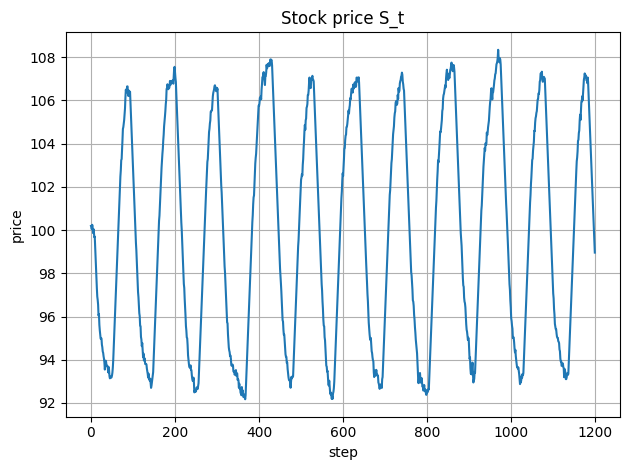

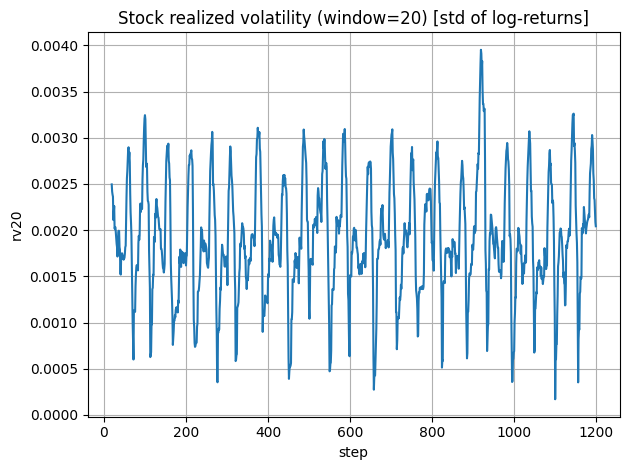

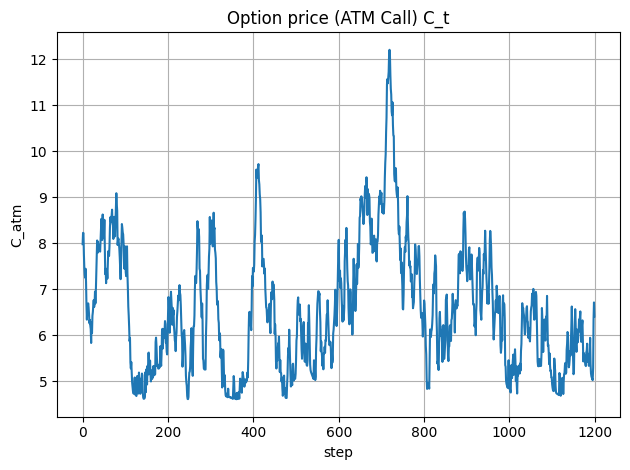

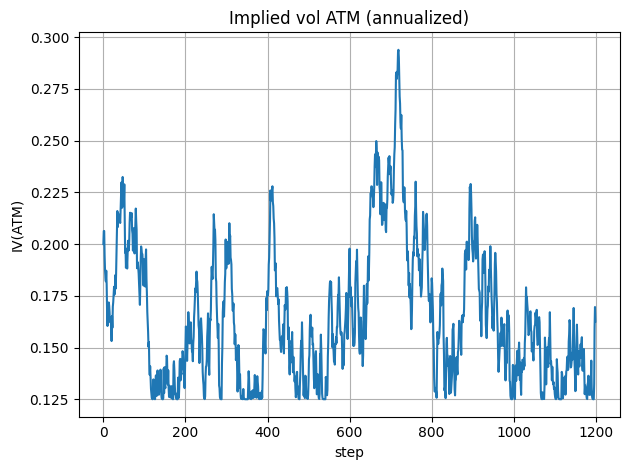

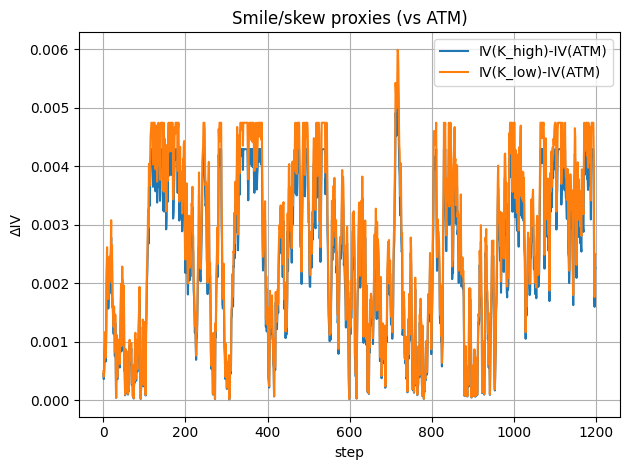

In [19]:
plot_stock_price(df)
plot_stock_realized_vol(df)
plot_option_price_atm(df)
plot_iv_atm(df)
plot_smile_strength(df)


In [9]:
df_all = sweep_p_heston(
    p_grid=(0.0, 0.25, 0.5, 0.75, 1.0),
    n_steps=1200,
    seeds=(SEED, SEED+1, SEED+2, SEED+3, SEED+4),
)

df_all[["t","S","rv20","iv_atm","smile_strength","rv_minus_iv","scenario_p_heston","seed"]].head()


,t,S,rv20,iv_atm,smile_strength,rv_minus_iv,scenario_p_heston,seed
0,0,100.190615,NaN,0.2,0.0,NaN,0.0,42
1,1,100.225981,NaN,0.2,0.0,NaN,0.0,42
2,2,100.125970,NaN,0.2,0.0,NaN,0.0,42
3,3,100.125304,NaN,0.2,0.0,NaN,0.0,42
4,4,99.995485,NaN,0.2,0.0,NaN,0.0,42


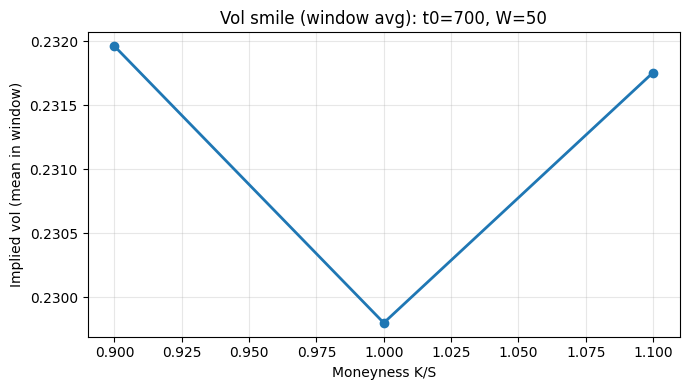

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# окно усреднения вокруг t0
t0 = 700
W = 50   # +/- 50 шагов
d = df.iloc[max(0,t0-W): min(len(df), t0+W+1)].dropna(subset=["S","iv_atm","iv_low","iv_high"])

# moneyness для 3 страйков
m = np.array([0.90, 1.00, 1.10])

S_mean = d["S"].mean()
K = m * S_mean

iv_low  = d["iv_low"].mean()
iv_atm  = d["iv_atm"].mean()
iv_high = d["iv_high"].mean()
IV = np.array([iv_low, iv_atm, iv_high])

plt.figure(figsize=(7,4))
plt.plot(m, IV, marker="o", linewidth=2)
plt.xlabel("Moneyness K/S")
plt.ylabel("Implied vol (mean in window)")
plt.title(f"Vol smile (window avg): t0={t0}, W={W}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# H1 Взаимодействие BS и Heston агентов порождает эндогенные режимные переключения (regime switching) в волатильности рынка.

In [21]:
from scipy.stats import ks_2samp

d = df_all.dropna(subset=["rv20"])

low  = d[d["scenario_p_heston"] <= 0.25]["rv20"]
high = d[d["scenario_p_heston"] >= 0.75]["rv20"]

ks, p = ks_2samp(low, high)

print("H1 KS-test")
print("KS =", ks)
print("p-value =", p)


H1 KS-test
KS = 0.2418289585097375
p-value = 1.8412944022278252e-304


### H1 / KS-test (сдвиг распределения rv20 при low vs high p_heston)

**Идея H1:** распределение realized volatility (rv20) отличается между сценариями с низкой и высокой долей Heston -> признак “режимов”/разных состояний волатильности.

* H0 (нулевая): распределения rv20 в группах low p_heston и high p_heston одинаковые
* H1 (альтернативная): распределения rv20 различаются

**Уровень значимости:** alpha = 0.05

**Результат теста:**

* KS statistic = **0.2418**
* p-value = **1.84e-304**

**Правило решения:**

* если p-value < 0.05 -> отвергаем H0
* если p-value ≥ 0.05 -> не отвергаем H0

**Вывод:**
Так как p-value < 0.05, мы отвергаем H0. Значит распределения rv20 при низкой и высокой доле Heston статистически значимо различаются. Это оддерживает H1

---


In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox

x = df["rv20"].dropna()

lb = acorr_ljungbox(x, lags=[10], return_df=True)
print("H1 Ljung-Box")
lb


H1 Ljung-Box


,lb_stat,lb_pvalue
10,3922.019651,0.0


### H1 / Ljung–Box (автокорреляция rv20 -> volatility clustering)

**Идея H1:** есть ли автокорреляция в волатильности (кластеризация), что типично для режимной динамики

* **H0:** в rv20 нет автокорреляции
* **H1:** в rv20 есть автокорреляция

**Уровень значимости:** alpha = 0.05

**Результат теста (lag=10):**

* lb_stat = 3922.0197
* p-value = 0.0 (около 0)

**Правило решения:**

* если **p-value < 0.05** -> отвергаем H0 (автокорреляция есть)
* если **p-value ≥ 0.05** -> не отвергаем H0

**Вывод:**
Так как p-value < 0.05, мы отвергаем H0. Значит rv20 демонстрирует автокорреляцию / volatility clustering, что поддерживает H1 (наличие эндогенной “структуры” в волатильности)

---

# H2 Чем выше доля Heston-агентов, тем сильнее выраженность volatility smile

In [23]:
from scipy.stats import f_oneway

groups = [
    df_all[df_all["scenario_p_heston"] == p]["smile_strength"].dropna()
    for p in [0.0, 0.25, 0.5, 0.75, 1.0]
]

F, p = f_oneway(*groups)

print("H2 ANOVA")
print("F =", F)
print("p-value =", p)


H2 ANOVA
F = 3506.072740564585
p-value = 0.0


### H2 / ANOVA (связь smile_strength и доли Heston)

**Идея H2:** меняется ли величина smile/skew при разных долях Heston

* **H0:** средние значения smile_strength одинаковы во всех группах доли Heston
* **H1:** хотя бы в одной группе среднее smile_strength отличается

**Уровень значимости:** alpha = 0.05

**Результат теста:**

* F = **3506.0727**
* p-value = **0.0**

**Правило решения:**

* если **p-value < 0.05** -> отвергаем H0
* если **p-value ≥ 0.05** -> не отвергаем H0

**Вывод:**
Так как p-value < 0.05, мы отвергаем H0. Это означает, что выраженность smile smile_strength статистически значимо зависит от доли Heston. Следовательно, H2 поддерживается (доля Heston влияет на smile)

---

# H3 Разные модели волатильности у агентов усиливают расхождение между realized volatility и implied volatility.

In [24]:
from scipy.stats import ttest_ind

d = df_all.dropna(subset=["rv_minus_iv"])

low  = d[d["scenario_p_heston"] <= 0.25]["rv_minus_iv"]
high = d[d["scenario_p_heston"] >= 0.75]["rv_minus_iv"]

t, p = ttest_ind(low, high, equal_var=False)

print("H3 t-test (RV-IV spread)")
print("t =", t)
print("p-value =", p)


H3 t-test (RV-IV spread)
t = 14.166212523962585
p-value = 3.238792536564591e-45


### H3 / t-test (RV–IV spread отличается при low vs high p_heston)

**Идея H3:** различие между realized vol и implied vol rv_minus_iv меняется в зависимости от типа агентов/доли Heston

* **H0:** среднее rv_minus_iv в low p_heston и high p_heston одинаковое
* **H1:** средние  rv_minus_iv различаются

**Уровень значимости:** alpha = 0.05

**Результат теста:**

* t = 14.1662
* p-value = 3.2388e-45

**Правило решения:**

* если **p-value < 0.05** ->  отвергаем H0
* если **p-value ≥ 0.05** -> не отвергаем H0

**Вывод:**
Так как p-value ≪ 0.05, мы отвергаем H0. Значит RV–IV spread rv_minus_iv *статистически значимо отличается между low и high p_heston. Это поддерживает H3: различия в волатильностных моделях у агентов усиливают/меняют расхождение между realized и implied volatility.

---
